# 10. Clustering Data into Groups

# 10.1. Using Centrality to Discover Clusters

Suppose a bull’s-eye is located at a coordinate of `[0, 0]`. A dart is thrown at that coordinate. We’ll model the x and y positions of the dart using 2 Normal distributions.

**Listing 10. 1. Modeling dart coordinates using 2 Normal distributions**

In [133]:
import numpy as np
np.random.seed(0)
mean = 0
variance = 2
x = np.random.normal(mean, variance ** 0.5)
y = np.random.normal(mean, variance ** 0.5)
print(f"The x coordinate of a randomly thrown dart is {x:.2f}")
print(f"The y coordinate of a randomly thrown dart is {y:.2f}")

The x coordinate of a randomly thrown dart is 2.49
The y coordinate of a randomly thrown dart is 0.57


Lets simulate 5,000 random darts tossed at the bulls'-eye positioned at `[0, 0]`. We'll also simulate 5,000 random darts tossed at a second bull's-eye, positioned at `[0, 6]`. Afterwards, we'll generate a scatter plot of all the random dart coordinates.

**Listing 10. 2. Simulating randomly thrown darts**

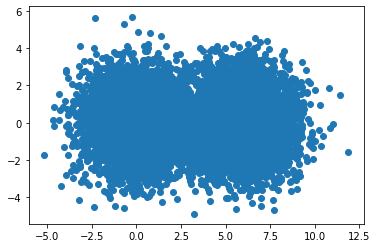

In [134]:
import matplotlib.pyplot as plt
np.random.seed(1)
bulls_eye1 = [0, 0]
bulls_eye2 = [6, 0]
bulls_eyes = [bulls_eye1, bulls_eye2]
x_coordinates, y_coordinates = [], []
for bulls_eye in bulls_eyes:
    for _ in range(5000):
        x = np.random.normal(bulls_eye[0], variance ** 0.5)
        y = np.random.normal(bulls_eye[1], variance ** 0.5)
        x_coordinates.append(x)
        y_coordinates.append(y)
        
plt.scatter(x_coordinates, y_coordinates)
plt.show()

Lets assign each dart to its nearest bull's-eye. We'll measure dart-proximity using **Euclidean distance**, which is the standard straight-line distance between 2 points. 

**Listing 10. 3. Assigning darts to the nearest bull’s-eye**

In [135]:
from scipy.spatial.distance import euclidean
def nearest_bulls_eye(dart):
    distances = [euclidean(dart, bulls_e) for bulls_e in bulls_eyes]
    return np.argmin(distances)

darts = [[0,1], [6, 1]]
for dart in darts:
    index = nearest_bulls_eye(dart)
    print(f"The dart at position {dart} is closest to bulls-eye {index}")

The dart at position [0, 1] is closest to bulls-eye 0
The dart at position [6, 1] is closest to bulls-eye 1


Now, we will apply the `nearest_bulls_eye` function to all our computed color coordinates. Afterwards, each dart-point will be plotted using one of 2 colors, in order to distinguish between the 2 bull's-eye assignments.

**Listing 10. 4. Coloring darts based on nearest bull’s-eye**

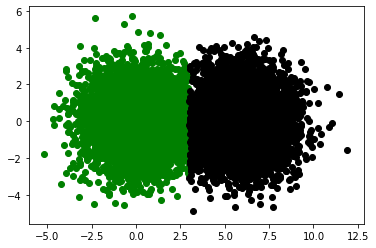

In [136]:
def color_by_cluster(darts):
    nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
    for bs_index in range(len(bulls_eyes)):
        selected_darts = [darts[i] for i in range(len(darts))
                          if bs_index == nearest_bulls_eyes[i]]
        x_coordinates, y_coordinates = np.array(selected_darts).T
        plt.scatter(x_coordinates, y_coordinates, 
                    color=['g', 'k'][bs_index])
    plt.show()

darts = [[x_coordinates[i], y_coordinates[i]]  
         for i in range(len(x_coordinates))]
color_by_cluster(darts)

The colored darts sensibly split into 2 even clusters. How would we identify such clusters if no central coordinates were provided? Well, one primitive strategy is to simply guess the location of the bull's-eyes.

**Listing 10. 5. Assigning darts to randomly chosen centers**

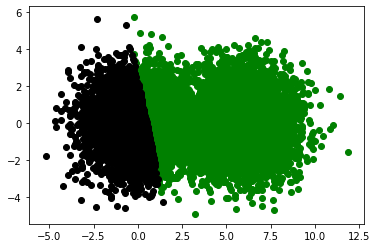

In [137]:
bulls_eyes = np.array(darts[:2])
color_by_cluster(darts)

Cluster B on the right seems to be stretching way too far to the left.  Lets remedy our error. We 'll compute the mean coordinates of all the points within the stretched right clustered group, and afterwards utilize these coordinates to adjust our estimation of the group's center. We will also reset the left-most cluster's center to its mean prior to re-running our centrality-based clustering.

**Listing 10. 6. Assigning darts to centers based on mean**

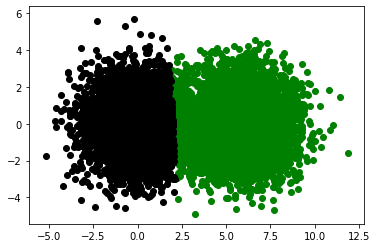

In [138]:
def update_bulls_eyes(darts):
    updated_bulls_eyes = []
    nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
    for bs_index in range(len(bulls_eyes)):
        selected_darts = [darts[i] for i in range(len(darts))
                          if bs_index == nearest_bulls_eyes[i]]
        x_coordinates, y_coordinates = np.array(selected_darts).T
        mean_center = [np.mean(x_coordinates), np.mean(y_coordinates)]
        updated_bulls_eyes.append(mean_center)
        
    return updated_bulls_eyes

bulls_eyes = update_bulls_eyes(darts)
color_by_cluster(darts)

The cluster's centers still appear a little off. Lets remedy the results by repeating the mean-based centrality adjustment over 10 additional iterations.

**Listing 10. 7. Adjusting bull’s-eye positions over 10 iterations**

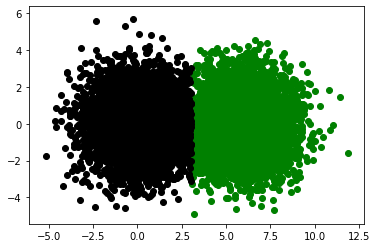

In [139]:
for i in range(10):
    bulls_eyes = update_bulls_eyes(darts)
    
color_by_cluster(darts)

Now the 2 sets of darts have been perfectly clustered. We have essentially replicated the  **K-means** clustering algorithm, which organizes data using centrality.

## 10.2. K-Means: A Clustering Algorithm for Grouping Data into K Central Groups

### 10.2.1. K-means Clustering Using Scikit-learn

A speedy implementation of the K-means algorithm is available through the external Scikit-Learn library. Lets import Scikit-learn's `KMeans` clustering class.

In [140]:
from sklearn.cluster import KMeans

Now, we'll use the `KMeans` class to cluster our `darts` data.

**Listing 10. 9. K-means clustering using Scikit-learn**

In [141]:
cluster_model = KMeans(n_clusters=2)
assigned_bulls_eyes = cluster_model.fit_predict(darts)

print("Bull's-eye assignments:")
print(assigned_bulls_eyes)

Bull's-eye assignments:
[1 1 1 ... 0 0 0]


Lets quickly color our darts based on their clustering assignments, in order to confirm that the assignments makes sense.

**Listing 10. 10. Plotting K-means cluster assignments**

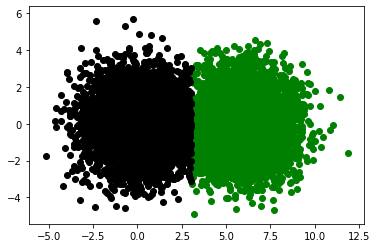

In [142]:
for bs_index in range(len(bulls_eyes)):
    selected_darts = [darts[i] for i in range(len(darts))
                      if bs_index == assigned_bulls_eyes[i]]
    x_coordinates, y_coordinates = np.array(selected_darts).T
    plt.scatter(x_coordinates, y_coordinates, 
                color=['g', 'k'][bs_index])
plt.show()

Our clustering model has located the centroids in the data. Now, we can reuse these centroids to analyze new data-points that the model has not seen before.

**Listing 10. 11. Using `cluster_model` to cluster new data**

In [143]:
new_darts = [[500, 500], [-500, -500]]
new_bulls_eye_assignments = cluster_model.predict(new_darts)
for i, dart in enumerate(new_darts):
    bulls_eye_index = new_bulls_eye_assignments[i]
    print(f"Dart at {dart} is closest to bull's-eye {bulls_eye_index}")

Dart at [500, 500] is closest to bull's-eye 0
Dart at [-500, -500] is closest to bull's-eye 1


### 10.2.2. Selecting the Optimal K Using the Elbow Method

We estimate an appropriate value for K using a technique known as the **Elbow method**. The Elbow method depends on a calculated value called **inertia**, which is the sum of the squared distances between each point and its closest K-means center. We'll run the technique by plotting the inertia of our dartboard dataset over a large range of K values.

**Listing 10. 12. Plotting the K-means inertia**

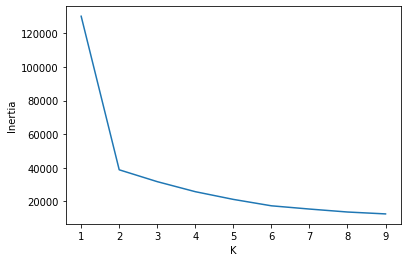

In [144]:
k_values = range(1, 10)
inertia_values = [KMeans(k).fit(darts).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

The generated plot resembles an arm bent at the elbow. The elbow points directly to a K of 2. What will happen if the number of centers is increased? We can find out by adding an additional bull's-eye to our dart-throwing simulation.

**Listing 10. 13. Plotting inertia for a 3-dartboard simulation**

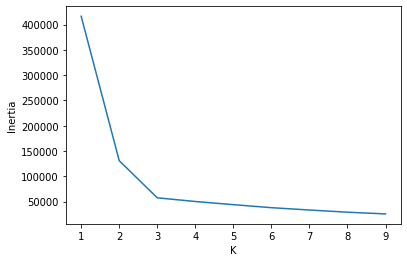

In [145]:
new_bulls_eye = [12, 0]
for _ in range(5000):
    x = np.random.normal(new_bulls_eye[0], variance ** 0.5)
    y = np.random.normal(new_bulls_eye[1], variance ** 0.5)
    darts.append([x, y])

inertia_values = [KMeans(k).fit(darts).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

## 10.3. Using Density to Discover Clusters

Suppose that an astronomer discovers a new planet at the far-flung edges of the solar system. The plant, much like our Saturn, has multiple rings spinning in constant orbit around its center. Each ring is formed from thousands of rocks. We'll model these rocks as individual points, defined by x and y coordinates.

**Listing 10. 14. Simulating rings around a planet**

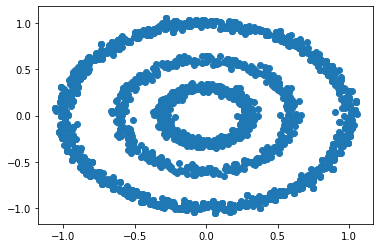

In [146]:
from sklearn.datasets import make_circles

x_coordinates = []
y_coordinates = []
for factor in [.3, .6, 0.99]:
    rock_ring, _ = make_circles(n_samples=800, factor=factor,
                                noise=.03, random_state=1)
    for rock in rock_ring:
        x_coordinates.append(rock[0])
        y_coordinates.append(rock[1])

plt.scatter(x_coordinates, y_coordinates)
plt.show()

Three ring-groups are clearly present in the plot. Lets search for these 3 clusters using K-means.

**Listing 10. 15. Using K-means to cluster rings**

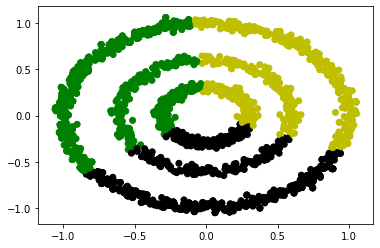

In [147]:
rocks = [[x_coordinates[i], y_coordinates[i]]  
          for i in range(len(x_coordinates))]
rock_clusters = KMeans(3).fit_predict(rocks)

colors = [['g', 'y', 'k'][cluster] for cluster in  rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors)
plt.show()

The output is an utter failure! We need to design an algorithm that will cluster data within dense regions of space. One simple definition of density is as follows; a point is in a dense region only if it's located within a distance `epsilon` of `min_points` other points.  Below, we'll set `epsilon` to 0.1 and `min_points` to 10.

**Listing 10. 16. Specifying density parameters**

In [148]:
epsilon=0.1
min_points = 10

Lets analyze the density of the first rock in our `rocks` list. We'll begin by searching for all the other rocks that are within `epsilon` units of `rocks[0]`.

**Listing 10. 17. Finding the neighbors of `rocks[0]`**

In [149]:
neighbor_indices = [i for i, rock in enumerate(rocks[1:])
                    if euclidean(rocks[0], rock) <= epsilon]

Now, we'll compare the number of neighbors to `min_points`, in order to determine if `rocks[0]` lies in a dense region of space.

**Listing 10. 18. Checking the density of `rocks[0]`**

In [150]:
num_neighbors = len(neighbor_indices)
print(f"The rock at index 0 has {num_neighbors} neighbors.")

if num_neighbors >= min_points:
    print("It lies in a dense region.")
else:
    print("It does not lie in a dense region.")

The rock at index 0 has 40 neighbors.
It lies in a dense region.


The rock at index 0 lies in a dense region of space. We can combine `rocks[0]` and its neighbors into a single dense cluster.

**Listing 10. 19. Creating a dense cluster**

In [151]:
dense_region_indices = [0] + neighbor_indices
dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We found a dense cluster containing {dense_cluster_size} rocks")

We found a dense cluster containing 41 rocks


The rock and index 0 and its neighbors form a single 41-element dense cluster. What about the neighbors of the neighbors? By analyzing additional neighboring points, we expand the size of `dense_region_cluster`.

**Listing 10. 20. Expanding a dense cluster**

In [152]:
dense_region_indices = set(dense_region_indices)
for index in neighbor_indices:
    point = rocks[index]
    neighbors_of_neighbors = [i for i, rock in enumerate(rocks)
                              if euclidean(point, rock) <= epsilon]
    if len(neighbors_of_neighbors) >= min_points:
        dense_region_indices.update(neighbors_of_neighbors)
            
dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We expanded our cluster to include {dense_cluster_size} rocks")

We expanded our cluster to include 781 rocks


We can expand our cluster even further by analyzing the density of newly encountered neighbors. Iteratively repeating our analysis will increase the breadth of our cluster boundary. This precedure is known as **DBSCAN**. The DBSCAN algorithm organizes data based on its density distribution.

## 10.4. DBSCAN: A Clustering Algorithm for Grouping Data Based on Spatial Density

Scikit-Learn makes DBSCAN available for use. We simply need to import the `DBSCAN` class from `sklearn.cluster`. Afterwards, we can initialize the class by assigning `epsilon` and `min_points` using the `eps` and `min_samples` parameters. Lets utilize `DBSCAN` to cluster our 3 rings.

**Listing 10. 21. Using `DBSCAN` to cluster rings**

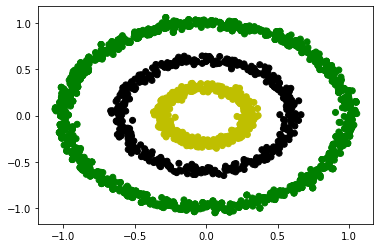

In [153]:
from sklearn.cluster import DBSCAN
cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
rock_clusters = cluster_model.fit_predict(rocks)
colors = [['g', 'y', 'k'][cluster] for cluster in rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors)
plt.show()

DBSCAN has successfully identified the 3 rock rings. The algorithm succeeded where K-means had failed.

### 10.4.1. Comparing DBSCAN and K-means

DBSCAN can filter random outliers located in sparse regions of space. For example, if we add an outlier located beyond the boundary of the rings, then DBSCAN will assign it a cluster id of -1. The negative value indicates that the outlier cannot be clustered with the rest of the dataset.

**Listing 10. 22. Finding outliers using DBSCAN**

In [154]:
noisy_data = rocks + [[1000, -1000]]
clusters = DBSCAN(eps=epsilon, 
                  min_samples=min_points).fit_predict(noisy_data)
assert clusters[-1] == -1

There is one other advantage to the DBSCAN technique that is missing from K-means. DBSCAN does not depend on Euclidean distance.

### 10.4.2. Clustering Based on Non-Euclidean Distance

Suppose we are visiting Manhattan. We wish to know the walking distance from the Empire State Building to Columbus Circle. The Empire State Building is located at the intersection of 34th street and 5th avenue. Meanwhile, Columbus Circle is located is located at the intersection of 57th street and 8th avenue. Our route requires us to walk 26 blocks total. Manhattan's average block-length is .17 miles. Lets compute that walking distance directly using a generalized `manhattan_distance` function.

**Listing 10. 23. Computing the Manhattan distance**

In [155]:
def manhattan_distance(point_a, point_b):
    num_blocks = np.sum(np.absolute(point_a - point_b))
    return .17 * num_blocks

x = np.array([34, 5])
y = np.array([57, 8])
distance = manhattan_distance(x, y)

print(f"Manhattan distance is {distance} miles")

Manhattan distance is 4.42 miles


Now, suppose we wish to cluster more than 2 Manhattan locations, using DBSCAN. We will pass `metric= manhattan_distance` into the initialization method. Consequently, the clustering distance will correctly reflect the grid-based constraints within the City.

**Listing 10. 24. Clustering using Manhattan distance**

Point at index 0 is in cluster 0
Point at index 1 is in cluster 0
Point at index 2 is in cluster 0
Point at index 3 is an outlier
Point at index 4 is an outlier


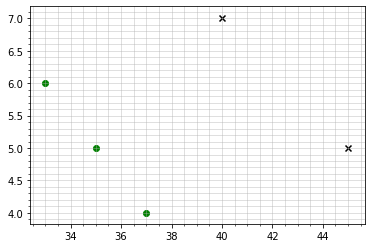

In [156]:
points = [[35, 5], [33, 6], [37, 4], [40, 7], [45, 5]]
clusters = DBSCAN(eps=1, min_samples=3,
                  metric=manhattan_distance).fit_predict(points)

for i, cluster in enumerate(clusters):
    point = points[i]
    if cluster == -1:
        print(f"Point at index {i} is an outlier")
        plt.scatter(point[0], point[1], marker='x', color='k')
    else:
        print(f"Point at index {i} is in cluster {cluster}")
        plt.scatter(point[0], point[1], color='g')

plt.grid(True, which='both', alpha=0.5)
plt.minorticks_on()

plt.show()

Unlike K-means, the DBSCAN algorithm does not require our distance function to be linearly divisible. Thus, we can easily run DBSCAN clustering using a ridiculous distance metric.

**Listing 10. 25. Clustering using a ridiculous measure of distance**

In [157]:
def ridiculous_measure(point_a, point_b):
    is_negative_a = np.array(point_a) < 0
    is_negative_b = np.array(point_b) < 0
    if is_negative_a.all() and is_negative_b.all():
        return 0
    elif is_negative_a.any() and is_negative_b.any():
        return 10
    else:
        return 2

points = [[-1, -1], [-10, -10], [-1000, -13435], [3,5], [5,-7]]
                   
clusters = DBSCAN(eps=.1, min_samples=2,
                  metric=ridiculous_measure).fit_predict(points)

for i, cluster in enumerate(clusters):
    point = points[i]
    if cluster == -1:
        print(f"{point} is an outlier")
    else:
        print(f"{point} falls in cluster {cluster}")

[-1, -1] falls in cluster 0
[-10, -10] falls in cluster 0
[-1000, -13435] falls in cluster 0
[3, 5] is an outlier
[5, -7] is an outlier


## 10.5. Analyzing Clusters Using Pandas

We can more intuitively analyze clustered rocks by combining the coordinates and the clusters together in a single Pandas table.

**Listing 10. 26. Storing clustered coordinates in a table**

In [158]:
import pandas as pd
x_coordinates, y_coordinates = np.array(rocks).T
df = pd.DataFrame({'X': x_coordinates, 'Y': y_coordinates,
                   'Cluster': rock_clusters})

Our Pandas table lets us easily access the rocks in any cluster. Lets plot those rocks that fall into cluster zero.

**Listing 10. 27. Plotting a single cluster using Pandas**

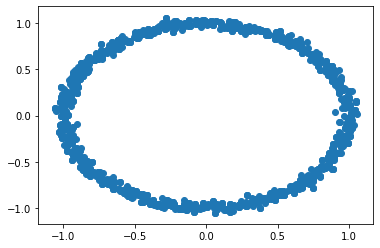

In [159]:
df_cluster = df[df.Cluster == 0]
plt.scatter(df_cluster.X, df_cluster.Y)
plt.show()

Pandas allows us to obtain a table containing elements from any single cluster. Alternatively, we might want to obtain multiple tables, where each table maps to a cluster id. In Pandas, this can easily be done by calling `df.groupby('Cluster')`.

**Listing 10. 28. Iterating over clusters using Pandas**

Skipping over cluster 0
Plotting cluster 1
Plotting cluster 2


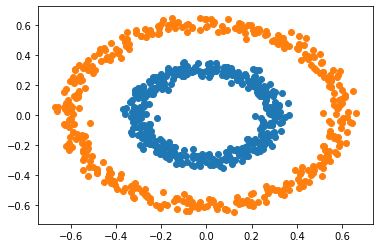

In [160]:
for cluster_id, df_cluster in df.groupby('Cluster'):
    if cluster_id == 0:
        print(f"Skipping over cluster {cluster_id}")
        continue
    
    print(f"Plotting cluster {cluster_id}")
    plt.scatter(df_cluster.X, df_cluster.Y)

plt.show()

# 11. Geographic Location Visualization and Analysis

## 11.1. The Great-Circle Distance: A Metric for Computing Distances Between 2 Global Points

The direct path between 2 points along the surface of a sphere is called the **great-circle distance**. That distance  depends on a series of well-known trigonometric operations.

**Listing 11. 1. Defining a great-circle distance function**

In [161]:
from math import cos, sin, asin

def great_circle_distance(x1, y1, x2, y2):
    delta_x, delta_y = x2 - x1, y2 - y2
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(x1), cos(x2), 
                                                   sin(delta_y / 2) ** 2])
    return 2 * asin(haversin ** 0.5)

Lets calculate the great-circle distance between 2 points that lie 180 degrees apart, relative to both the x-axis and the y-axis.

**Listing 11. 2. Computing the great-circle distance**

In [162]:
from math import pi
distance = great_circle_distance(0, 0, pi, pi)
print(f"The distance equals {distance} units")

The distance equals 3.141592653589793 units


The points are exactly π units apart, half the distance required to circumnavigate a unit-circle. This is akin to traveling between the North and South Poles of any planet. We'll confirm by analyzing the latitudes and longitudes of Earth's North Pole and South Pole. Lets begin by recording the known coordinates of each pole.

In [163]:
latitude_north, longitude_north = (90.0, 0)
latitude_south, longitude_south = (-90.0, 0)

Latitudes and longitudes measure spherical coordinates in degrees, not radians. We'll thus convert to radians from degrees using the `np.radians` function. Afterwards, we'll input the radian results into `great_circle_distance`.

**Listing 11. 4. Computing the great-circle distance between poles**

In [164]:
to_radians =  np.radians([latitude_north, longitude_north, 
                          latitude_south, longitude_south])
distance = great_circle_distance(*to_radians.tolist())
print(f"The unit-circle distance between poles equals {distance} units")

The unit-circle distance between poles equals 3.141592653589793 units


As expected, the distance between poles on a unit-sphere is π . Now, let's measure the distance between 2 poles here on Earth. The radius of the Earth is not 1 hypothetical unit, but rather 3956 actual miles.

**Listing 11. 5. Computing the travel distance between Earth’s poles**

In [165]:
earth_distance = 3956 * distance
print(f"The distance between poles equals {earth_distance} miles")

The distance between poles equals 12428.14053760122 miles


Lets create a general `travel_distance` function to calculate the travel mileage between any 2 terrestrial points.

**Listing 11. 6. Defining a travel distance function**

In [166]:
def travel_distance(lat1, lon1, lat2, lon2):
    to_radians =  np.radians([lat1, lon1, lat2, lon2])
    return 3956 * great_circle_distance(*to_radians.tolist())

assert travel_distance(90, 0, -90, 0) == earth_distance

## 11.2. Plotting Maps Using Basemap

Basemap is a Matplotlib extension for generating maps in Python. Lets install the Basemap library, a import the `Basemap` mapping class. Afterwards, we'll initialize the class as `map_plotter = Basemap()`.

**Listing 11. 7. Initializing the Basemap mapping class**

In [167]:
from mpl_toolkits.basemap import Basemap
map_plotter = Basemap()

We are ready to visualize the Earth, by plotting the coastline boundaries of all 7 continents.

**Listing 11. 8. Visualizing the Earth using Basemap**

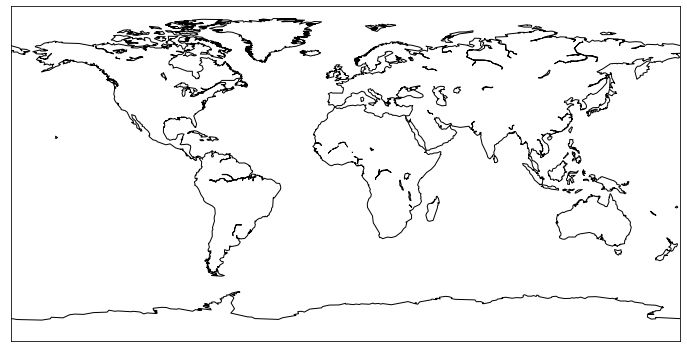

In [168]:
# Basemap usage generates warning outputs within the Jupyter notebook. 
# We'll use `warnings` module to deactivate these distracting outputs.
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(12, 8))
map_plotter.drawcoastlines()
plt.show()

National boundaries are currently missing from the plot. We can incorporate country boundaries by calling the `map_plotter.drawcountries()` method.

**Listing 11. 9. Mapping coastlines and countries**

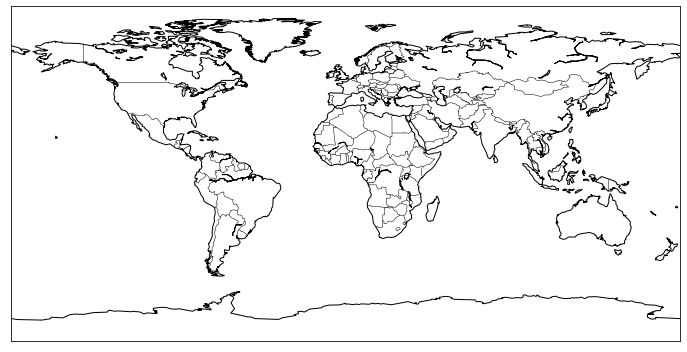

In [169]:
fig = plt.figure(figsize=(12, 8))
map_plotter.drawcoastlines()
map_plotter.drawcountries()
plt.show()

So far our map looks sparse and uninviting. We can improve the quality by calling `map_plotter.shadedrelief()`. The method-call will color the map using topographic information.

**Listing 11. 10. Coloring a map of the Earth**

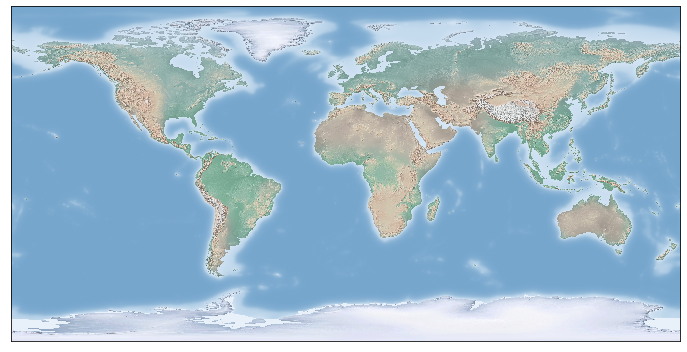

In [170]:
fig = plt.figure(figsize=(12, 8))
map_plotter.shadedrelief()
plt.show()

Suppose we are given a list of locations defined by pairs of latitudes and longitudes. We can plot these locations on our map by separating the latitudes from the longitudes and then passing the results into `map_plotter.scatter`.

**Listing 11. 11. Plotting coordinates on a map**

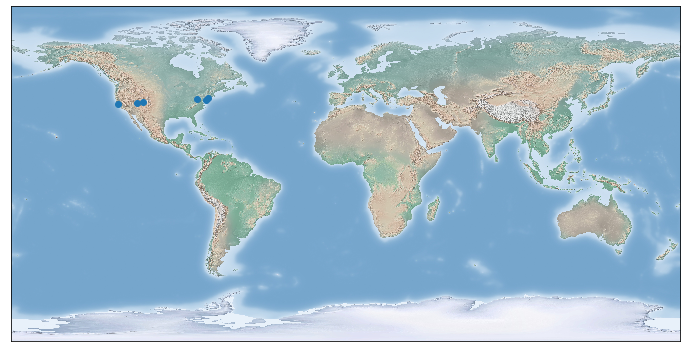

In [171]:
fig = plt.figure(figsize=(12, 8))
coordinates = [(39.9526, -75.1652), (37.7749, -122.4194),
               (40.4406, -79.9959), (38.6807, -108.9769),
               (37.8716, -112.2727), (40.7831, -73.9712)]

latitudes, longitudes = np.array(coordinates).T
map_plotter.scatter(longitudes, latitudes, latlon=True)
map_plotter.shadedrelief()
plt.show()

The plotted points all appear within the boundaries of North America. We thusly can simplify the map by zooming in on North America. In order to adjust the map, we must alter our projection.

**Listing 11. 12. Plotting North American Coordinates**

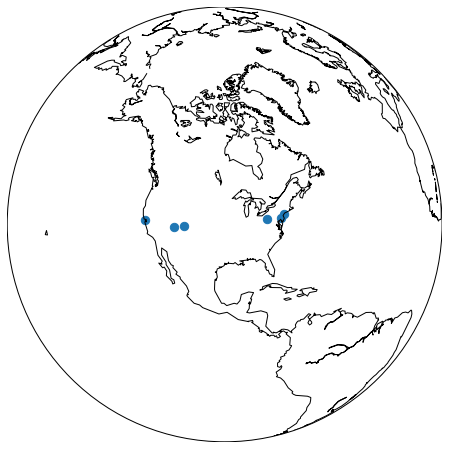

In [172]:
fig = plt.figure(figsize=(12, 8))
map_ortho = Basemap(projection='ortho', lat_0=40, lon_0=-95)
map_ortho.scatter(longitudes, latitudes, latlon=True,
                  s=70)
map_ortho.drawcoastlines()
plt.show()

We successfully zoomed in on North America. Now, we'll zoom in further, onto the United States.

**Listing 11. 13. Plotting USA Coordinates**

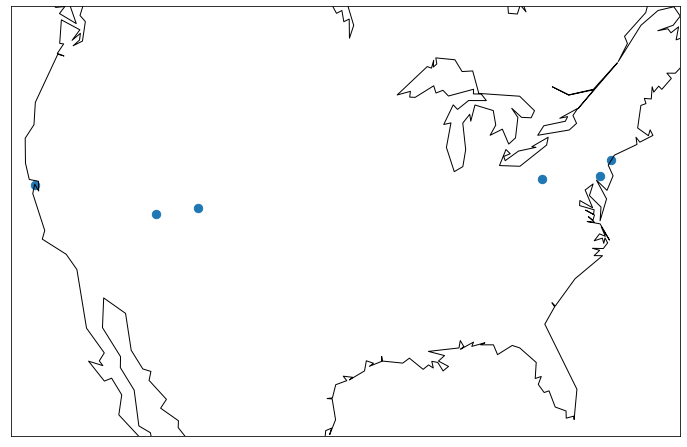

In [173]:
fig = plt.figure(figsize=(12, 8))
map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, 
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33, 
                  lat_2=45)

map_lcc.scatter(longitudes, latitudes, latlon=True, s=70)
map_lcc.drawcoastlines()
plt.show()

Our map of the United States is looking a little sparse. Lets add state boundaries to the map by calling `map_lcc.drawstates()`.

**Listing 11. 14. Mapping state boundaries in the USA**

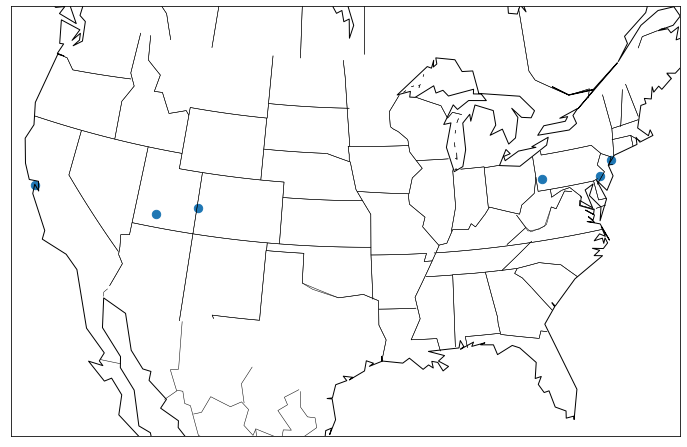

In [174]:
fig = plt.figure(figsize=(12, 8))
map_lcc.scatter(longitudes, latitudes, latlon=True, s=70)
map_lcc.drawcoastlines()
map_lcc.drawstates()
plt.show()

Basemap allows us to plot any location on a map. All we need is the location’s latitude and longitude. Thus, we need a mapping between location names and their geographic properties. That mapping is provided by the GeoNamesCache location-tracking library.

## 11.3. Location Tracking Using GeoNamesCache

GeoNamesCache is designed to efficiently retrieve data pertaining to continents, countries, and cities, as well US counties and US states. Lets install the library and explore its usage in more detail. We'll begin by initializing a `GeonamesCache` location-tracking object.

In [175]:
from geonamescache import GeonamesCache
gc = GeonamesCache()

Lets use our `gc` object to explore the 7 continents. We'll run `gc.get_continents()` in order to retrieve a dictionary of continent-related information.

**Listing 11. 16. Fetching all 7 continents from GeoNamesCache**

In [176]:
continents = gc.get_continents()
print(continents.keys())

dict_keys(['AF', 'AS', 'EU', 'NA', 'OC', 'SA', 'AN'])


The dictionary keys represent shorthand encoding of continent names, in which __Africa__ is transformed into `'AF'`, and __North America__ is transformed into `'NA'`. Lets check the values mapped to every key by passing in the code for __North America__.

**Listing 11. 17. Fetching North America from GeoNamesCach**

In [177]:
north_america = continents['NA']
print(north_america.keys())

dict_keys(['lng', 'geonameId', 'timezone', 'bbox', 'toponymName', 'asciiName', 'astergdem', 'fcl', 'population', 'wikipediaURL', 'adminName5', 'srtm3', 'adminName4', 'adminName3', 'alternateNames', 'cc2', 'adminName2', 'name', 'fclName', 'fcodeName', 'adminName1', 'lat', 'fcode', 'continentCode'])


Many of the `north_america` data elements represent the various naming schemes for the North American continent. Such information is not very useful.

**Listing 11. 18. Printing North America’s naming schemas**

In [178]:
for name_key in ['name', 'asciiName', 'toponymName']:
    print(north_america[name_key])

North America
North America
North America


The  `'lat'` and the `'lng'` keys map to the latitude and longitude of the central-most location in the continent. We can utilize these coordinates to plot a map projection centered at the heart of North America.

**Listing 11. 19. Mapping North America’s central coordinates**

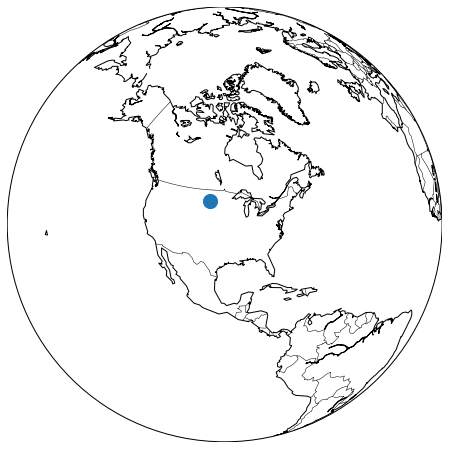

In [179]:
latitude = float(north_america['lat'])
longitude = float(north_america['lng'])

fig = plt.figure(figsize=(12, 8))
map_plotter = Basemap(projection='ortho',lat_0=40, lon_0=-95)
map_plotter.scatter([longitude], [latitude], latlon=True, s=200)
map_plotter.drawcoastlines()
map_plotter.drawcountries()
plt.show()

## 10.3.1. Accessing Country Information
We can analyze countries using the `get_countries` method. It returns a dictionary whose 2-character keys encode the names of 252 different countries. Accessing `gc.get_countries()['US']` will return a dictionary containing useful USA statistics. Lets output all the non-city information pertaining to the United States.

**Listing 11. 20. Fetching US data from GeoNamesCache**

In [180]:
countries = gc.get_countries()
num_countries = len(countries)
print(f"GeonamesCache holds data for {num_countries} countries.")

us_data = countries['US']
print("The following data pertains to the United States:")
print(us_data)

GeonamesCache holds data for 252 countries.
The following data pertains to the United States:
{'geonameid': 6252001, 'name': 'United States', 'iso': 'US', 'iso3': 'USA', 'isonumeric': 840, 'fips': 'US', 'continentcode': 'NA', 'capital': 'Washington', 'areakm2': 9629091, 'population': 310232863, 'tld': '.us', 'currencycode': 'USD', 'currencyname': 'Dollar', 'phone': '1', 'postalcoderegex': '^\\d{5}(-\\d{4})?$', 'languages': 'en-US,es-US,haw,fr', 'neighbours': 'CA,MX,CU'}


There is valuable information within each country's `'neighbours'` element. It maps to a comma-delimited string
of country codes that signify all neighboring territories. We can obtain more details about each neighbor by splitting the string and passing the codes into the `'countries'` dictionary.

**Listing 11. 21. Fetching neighboring countries**

In [181]:
us_neighbors = us_data['neighbours']
for neighbor_code in us_neighbors.split(','):
    print(countries[neighbor_code]['name'])

Canada
Mexico
Cuba


We can also query all countries by name using the `get_countries_by_names` method. This method returns a dictionary whose elements are country names rather than codes.

**Listing 11. 22. Fetching countries by name**

In [182]:
result = gc.get_countries_by_names()['United States']
assert result == countries['US']
countries['US']

{'geonameid': 6252001,
 'name': 'United States',
 'iso': 'US',
 'iso3': 'USA',
 'isonumeric': 840,
 'fips': 'US',
 'continentcode': 'NA',
 'capital': 'Washington',
 'areakm2': 9629091,
 'population': 310232863,
 'tld': '.us',
 'currencycode': 'USD',
 'currencyname': 'Dollar',
 'phone': '1',
 'postalcoderegex': '^\\d{5}(-\\d{4})?$',
 'languages': 'en-US,es-US,haw,fr',
 'neighbours': 'CA,MX,CU'}

## 10.3.2. Accessing City Information

The `get_cities` method returns a dictionary whose keys are unique ids mapping back to city data.

**Listing 11. 23. Fetching cities from GeoNamesCache**

In [183]:
cities = gc.get_cities()
num_cities = len(cities)
print(f"GeoNamesCache holds data for {num_cities} total cities")
city_id = list(cities.keys())[0]
print(cities[city_id])

GeoNamesCache holds data for 24200 total cities
{'geonameid': 3041563, 'name': 'Andorra la Vella', 'latitude': 42.50779, 'longitude': 1.52109, 'countrycode': 'AD', 'population': 20430, 'timezone': 'Europe/Andorra'}


The data for each city contains the reference code for the country where that city is located. By utilizing the country code, we can create a new mapping between a country and all its territorial cities.

**Listing 11. 24. Fetching US cities from GeoNamesCache**

In [184]:
us_cities = [city for city in cities.values() 
             if city['countrycode'] == 'US']
num_us_cities = len(us_cities)
print(f"GeoNamesCache holds data for {num_us_cities} US cities.")

GeoNamesCache holds data for 3248 US cities.


Lets find the average US latitude and longitude. This average will approximate the central coordinates of the United States.

**Listing 11. 25. Approximating US central coordinates**

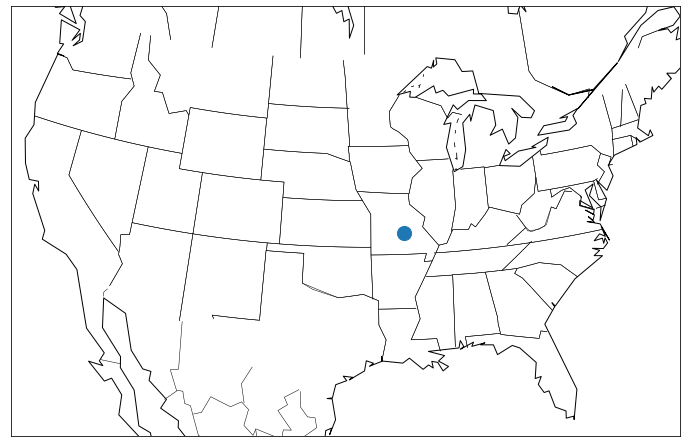

In [185]:
center_lat = np.mean([city['latitude'] 
                      for city in us_cities])
center_lon = np.mean([city['longitude'] 
                       for city in us_cities])

fig = plt.figure(figsize=(12, 8))
map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, 
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33, 
                  lat_2=45)
map_lcc.scatter([center_lon], [center_lat], latlon=True, s=200)
map_lcc.drawcoastlines()
map_lcc.drawstates()
plt.show()

The `get_cities` method is suitable for iterating over city information, but not for querying cities by name. To run a name-based city search, we must rely on `get_cities_by_name`. 

**Listing 11. 26. Fetching cities by name**

In [186]:
matched_cities_list = gc.get_cities_by_name('Philadelphia')
print(matched_cities_list)

[{'4560349': {'geonameid': 4560349, 'name': 'Philadelphia', 'latitude': 39.95233, 'longitude': -75.16379, 'countrycode': 'US', 'population': 1567442, 'timezone': 'America/New_York'}}]


The `get_cities_by_name` method may return more than one city, because city-names are not always unique. For example, GeoNamesCache contains 6 different instances of the city __San Francisco__, spanning across 5 different countries.

**Listing 11. 27. Fetching multiple cities with a shared name**

In [187]:
matched_cities_list = gc.get_cities_by_name('San Francisco')

for i, san_francisco in enumerate(matched_cities_list):
    city_info = list(san_francisco.values())[0]
    country_code = city_info['countrycode']
    country = countries[country_code]['name']
    print(f"The San Francisco at index {i} is located in {country}")

The San Francisco at index 0 is located in Argentina
The San Francisco at index 1 is located in Costa Rica
The San Francisco at index 2 is located in Philippines
The San Francisco at index 3 is located in Philippines
The San Francisco at index 4 is located in El Salvador
The San Francisco at index 5 is located in United States


Its common for multiple cities to share the same name. Choosing among such cities is quite difficult. Usually, the safest guess is the city with the largest population. 

**Listing 11. 28. Mapping the most populous San Francisco**

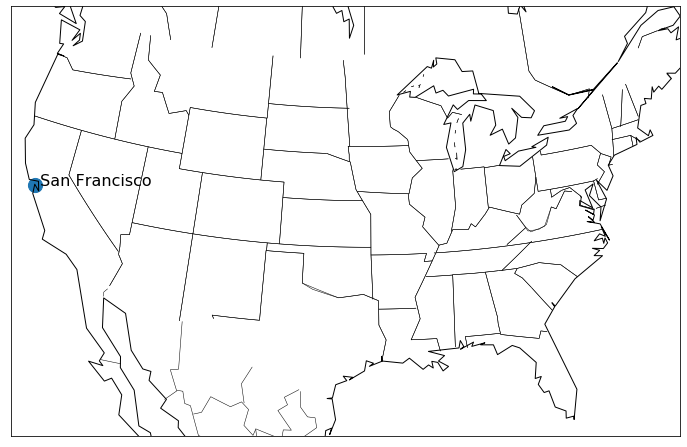

In [188]:
best_sf = max(gc.get_cities_by_name('San Francisco'), 
              key=lambda x: list(x.values())[0]['population'])
sf_data = list(best_sf.values())[0]
sf_lat = sf_data['latitude']
sf_lon = sf_data['longitude']

fig = plt.figure(figsize=(12, 8))
map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, 
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33, 
                  lat_2=45)
map_lcc.scatter([sf_lon], [sf_lat], latlon=True, s=200)
map_lcc.drawcoastlines()
map_lcc.drawstates()

x, y = map_lcc(sf_lon, sf_lat)
plt.text(x, y, ' San Francisco', fontsize=16)
plt.show()

### 10.3.3. Limitations of the GeoNamesCache Library

The `get_cities_by_name` method maps only one version of a city's name to its geographic data. This poses a problem for cities like __New York__, which carry more than one commonly referenced name.

**Listing 11. 29. Fetching New York City from GeoNamesCache**

In [189]:
for ny_name in ['New York', 'New York City']:
    if not gc.get_cities_by_name(ny_name):
        print(f"'{ny_name}' is not present in GeoNamesCache database.")
    else:
        print(f"'{ny_name}' is present in GeoNamesCache database.")

'New York' is not present in GeoNamesCache database.
'New York City' is present in GeoNamesCache database.


The limits of single references become particularly obvious when we examine diacritics in city names. Diacritics are accent marks that designate the proper pronunciation of foreign-sounding words. 

**Listing 11. 30. Fetching accented cities from GeoNamesCache**

In [190]:
print(gc.get_cities_by_name(u'Cañon City'))
print(gc.get_cities_by_name(u'Hagåtña'))

[{'5416005': {'geonameid': 5416005, 'name': 'Cañon City', 'latitude': 38.44098, 'longitude': -105.24245, 'countrycode': 'US', 'population': 16400, 'timezone': 'America/Denver'}}]
[{'4044012': {'geonameid': 4044012, 'name': 'Hagåtña', 'latitude': 13.47567, 'longitude': 144.74886, 'countrycode': 'GU', 'population': 1051, 'timezone': 'Pacific/Guam'}}]


How many of the cities stored in GeoNamesCache contain diacritics in their name? We can find out using the `unidecode` function from the external Unidecode library.

**Listing 11. 31. Counting all accented cities in GeoNamesCache**

In [191]:
from unidecode import unidecode
accented_names = [city['name'] for city in gc.get_cities().values()
                  if city['name'] != unidecode(city['name'])]
num_accented_cities = len(accented_names)

print(f"An example accented city name is '{accented_names[0]}'")
print(f"{num_accented_cities} cities have accented names") 

An example accented city name is 'Khawr Fakkān'
4896 cities have accented names


We can now match the stripped dictionary keys against all inputted text by passing the accented dictionary values into GeoNamesCache, whenever a key-match is found.

**Listing 11. 33. Finding accent-free city-names in text**

In [192]:
alternative_names = {unidecode(name): name 
                     for name in accented_names}
print(gc.get_cities_by_name(alternative_names['Hagatna']))

[{'4044012': {'geonameid': 4044012, 'name': 'Hagåtña', 'latitude': 13.47567, 'longitude': 144.74886, 'countrycode': 'GU', 'population': 1051, 'timezone': 'Pacific/Guam'}}]


## 10.4. Matching Location Names in Text

In Python, we can easily determine if one string is a substring of another, or if the start of a string contains some predefined text.

**Listing 11. 34. Basic string matching**

In [193]:
text = u'This sentence matches Hagatna'
for key, value in alternative_names.items():
    if key in text:
        print(gc.get_cities_by_name(value))
        break

[{'4044012': {'geonameid': 4044012, 'name': 'Hagåtña', 'latitude': 13.47567, 'longitude': 144.74886, 'countrycode': 'GU', 'population': 1051, 'timezone': 'Pacific/Guam'}}]


In more complex analyses, Python's basic string syntax can be quite limiting. For example, Python's string methods can't directly distinguish between sub-characters in a string and sub-phrases in a sentence.

**Listing 11. 35. Basic sub-string matching errors**

In [194]:
assert 'in a' in 'sin apple'
assert 'in a' in 'win attached'

To overcame these limitations, we must rely on Python's built-in regular expression processing library, `re`. A **regular expression** (or **regex** for short) is a string-encoded pattern that can be compared against some text. Most regex-matching in Python can be executed with the `re.search` function. 

**Listing 11. 36. String matching using regexes**

In [195]:
import re
regex = 'Boston'
random_text = 'Clown Patty'
match = re.search(regex, random_text)
assert match is None

matchable_text = 'Boston Marathon'
match = re.search(regex, matchable_text)
assert match is not None
start, end = match.start(), match.end()
matched_string = matchable_text[start: end]
assert matched_string == 'Boston'

Case-insensitive string matching is a breeze with `re.search`. We simply pass `re.IGNORECASE` as an added `flags` parameter.

**Listing 11. 37. Case-insensitive matching using regexes**

In [196]:
for text in ['BOSTON', 'boston', 'BoSTOn']:
    assert re.search(regex, text, flags=re.IGNORECASE) is not None

Also, regexes permit us to match exact words, and not just substrings, using word boundary detection.

**Listing 11. 38. Word boundary matching using regexes**

In [197]:
for regex in ['\\bin a\\b', r'\bin a\b']:
    for text in ['sin apple', 'win attached']:
        assert re.search(regex, text) is None
        
    text = 'Match in a string'
    assert re.search(regex, text) is not None

Now, let us carry out a more complicated match. We'll match against the sentence `f'I visited {city} yesterday`, where `{city}` represents one of 3 possible locations; `'Boston'`, `'Philadelphia'`, or `'San Francisco'`.

**Listing 11. 39. Multi-city matching using regexes**

In [198]:
regex = r'I visited \b(Boston|Philadelphia|San Francisco)\b yesterday.'
assert re.search(regex, 'I visited Chicago yesterday.') is None

cities = ['Boston', 'Philadelphia', 'San Francisco']
for city in cities:
    assert re.search(regex, f'I visited {city} yesterday.') is not None

Suppose we want to match a regex against 100 strings. For every match, `re.search`  will transform the regex into Python `PatternObject.` Each such transformation is computationally costly. We're better off executing the transformation only once using `re.compile`.

**Listing 11. 40. String matching using compiled regexes**

In [199]:
compiled_re = re.compile(regex)
text = 'I visited Boston yesterday.'
for i in range(1000):
    assert compiled_re.search(text) is not None

# 12. Case Study 3 Solution

## 12.2. Extracting Locations from Headline Data

We'll begin by loading the headline data.

**Listing 12. 1. Loading headline data**

In [200]:
headline_file = open('headlines.txt','r')
headlines = [line.strip() 
             for line in headline_file.readlines()]
num_headlines = len(headlines)
print(f"{num_headlines} headines have been loaded")

650 headines have been loaded


We need a mechanism for extracting city and country names from the headline text. One naïve solution is to match the locations in GeoNamesCache against each and every headline.  However, for more optimal matching, we should transform each location name into a case-independent and accent-independent regular expression. Lets execute these transformations using a custom `name_to_regex` function. 

**Listing 12. 2. Converting names to regexes**

In [201]:
def name_to_regex(name):
    decoded_name = unidecode(name)
    if name != decoded_name:
        regex = fr'\b({name}|{decoded_name})\b'
    else:
        regex = fr'\b{name}\b'
    return re.compile(regex, flags=re.IGNORECASE)

Using `name_to_regex`, we can create create a mapping between regular expressions and the original names in GeoNamesCache.

**Listing 12. 3. Mapping names to regexe**

In [202]:
countries = [country['name'] 
             for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name 
                   for name in countries}
                   
cities = [city['name'] for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

Next, we’ll use our mappings to define a function that will look for location names in text

**Listing 12. 4. Finding locations in text**

In [203]:
def get_name_in_text(text, dictionary):
    for regex, name in sorted(dictionary.items(), 
                              key=lambda x: x[1]):
        if regex.search(text):
            return name
    return None

We'll utilize `get_names_in_text` to discover the cities and countries that are mentioned in the `headlines` list. Afterwards, we'll store the results in a Pandas table for easier analysis.

**Listing 12. 5. Finding locations in headlines**

In [204]:
import pandas as pd

matched_countries = [get_name_in_text(headline, country_to_name)
                     for headline in headlines]
matched_cities = [get_name_in_text(headline, city_to_name)
                  for headline in headlines]
data = {'Headline': headlines, 'City': matched_cities, 
        'Country': matched_countries}
df = pd.DataFrame(data)

Lets explore our location table. We'll start by summarizing the contents of `df` using the `describe` method.

**Listing 12. 6. Summarizing the location data**

In [205]:
summary = df[['City', 'Country']].describe()
print(summary)

       City   Country
count   619        15
unique  511        10
top      Of  Malaysia
freq     45         3


The most frequently mentioned city is apparently __Of, Turkey__. The 45 instances of __Of__ are more likely
to match the preposition than the rarely referenced Turkish location. We will output some instances of __Of__ in order to confirm the error.

**Listing 12. 7. Fetching cities named __Of__**

In [206]:
of_cities = df[df.City == 'Of'][['City', 'Headline']]
ten_of_cities = of_cities.head(10)
print(ten_of_cities.to_string(index=False))

City                                           Headline
  Of              Case of Measles Reported in Vancouver
  Of  Authorities are Worried about the Spread of Br...
  Of  Authorities are Worried about the Spread of Ma...
  Of  Rochester authorities confirmed the spread of ...
  Of     Tokyo Encounters Severe Symptoms of Meningitis
  Of  Authorities are Worried about the Spread of In...
  Of            Spike of Pneumonia Cases in Springfield
  Of  The Spread of Measles in Spokane has been Conf...
  Of                    Outbreak of Zika in Panama City
  Of    Urbana Encounters Severe Symptoms of Meningitis


In all the wrongly matched headlines we matched to __Of__ but not to the actual city
name. The mismatches occurred because we didn't consider potential multiple matches in a headline. How frequently do headlines contain 2 or more city matches? Lets find out. 

**Listing 12. 8. Finding multi-city headlines**

In [207]:
def get_cities_in_headline(headline):
    cities_in_headline = set()
    for regex, name in city_to_name.items():          
        match = regex.search(headline)
        if match:
            if headline[match.start()].isupper():
                cities_in_headline.add(name)
                
    return list(cities_in_headline)

df['Cities'] = df['Headline'].apply(get_cities_in_headline)
df['Num_cities'] = df['Cities'].apply(len)
df_multiple_cities = df[df.Num_cities > 1]
num_rows, _ = df_multiple_cities.shape
print(f"{num_rows} headlines match multiple cities")

67 headlines match multiple cities


67 headlines contain more than one city, representing approximately 10% of the data. Why are so many headlines matching against multiple locations? Perhaps exploring some sample matches will yield an answer.

**Listing 12. 9. Sampling multi-city headlines**

In [208]:
ten_cities = df_multiple_cities[['Cities', 'Headline']].head(10)
print(ten_cities.to_string(index=False))

                        Cities                                           Headline
         [New York City, York]                    Could Zika Reach New York City?
          [Miami, Miami Beach]                  First Case of Zika in Miami Beach
               [San, San Juan]  San Juan reports 1st U.S. Zika-related death a...
    [Los Ángeles, Los Angeles]               New Los Angeles Hairstyle goes Viral
                  [Tampa, Bay]              Tampa Bay Area Zika Case Count Climbs
        [Ho Chi Minh City, Ho]     Zika cases in Vietnam's Ho Chi Minh City surge
              [San Diego, San]           Key Zika Findings in San Diego Institute
           [Hīt, Kuala Lumpur]                 Kuala Lumpur is Hit By Zika Threat
          [San Francisco, San]                   Zika Virus Reaches San Francisco
 [Salvador, San, San Salvador]                       Zika worries in San Salvador


Short, invalid city names are getting matched to the headlines along with longer, more correct location names. One solution is simply to assign the longest city-name as the representative location if more than one matched city is found.

**Listing 12. 10. Selecting the longest city names**

In [209]:
def get_longest_city(cities):
    if cities:
        return max(cities, key=len)
    return None

df['City'] = df['Cities'].apply(get_longest_city)

As a sanity check, we'll output those rows in the the table that contain a short city-name (4 characters or less), in order to ensure that no erroneous short name is getting assigned to one of our headlines.

**Listing 12. 11. Printing the shortest city names**

In [210]:
short_cities = df[df.City.str.len() <= 4][['City', 'Headline']]
print(short_cities.to_string(index=False))

 City                                           Headline
 Lima                Lima tries to address Zika Concerns
 Pune                     Pune woman diagnosed with Zika
 Rome  Authorities are Worried about the Spread of Ma...
 Molo                Molo Cholera Spread Causing Concern
 Miri                               Zika arrives in Miri
 Nadi  More people in Nadi are infected with HIV ever...
 Baud  Rumors about Tuberculosis Spreading in Baud ha...
 Kobe                     Chikungunya re-emerges in Kobe
 Waco                More Zika patients reported in Waco
 Erie                        Erie County sets Zika traps
 Kent                       Kent is infested with Rabies
 Reno  The Spread of Gonorrhea in Reno has been Confi...
 Sibu                      Zika symptoms spotted in Sibu
 Baku    The Spread of Herpes in Baku has been Confirmed
 Bonn  Contaminated Meat Brings Trouble for Bonn Farmers
 Jaen                         Zika Troubles come to Jaen
 Yuma                       Zik

Let's now shift our attention from cities to countries. Only 15 of the total headlines contain actual country information. The count is low enough for us to manually examine all these headlines.

**Listing 12. 12. Fetching headlines with countries**

In [211]:
df_countries = df[df.Country.notnull()][['City', 
                                         'Country', 
                                         'Headline']]
print(df_countries.to_string(index=False))

             City    Country                                           Headline
           Recife     Brazil            Mystery Virus Spreads in Recife, Brazil
 Ho Chi Minh City    Vietnam     Zika cases in Vietnam's Ho Chi Minh City surge
          Bangkok   Thailand                     Thailand-Zika Virus in Bangkok
       Piracicaba     Brazil                Zika outbreak in Piracicaba, Brazil
            Klang   Malaysia                   Zika surfaces in Klang, Malaysia
   Guatemala City  Guatemala  Rumors about Meningitis spreading in Guatemala...
      Belize City     Belize                 Belize City under threat from Zika
         Campinas     Brazil                   Student sick in Campinas, Brazil
      Mexico City     Mexico               Zika outbreak spreads to Mexico City
    Kota Kinabalu   Malaysia           New Zika Case in Kota Kinabalu, Malaysia
      Johor Bahru   Malaysia                 Zika reaches Johor Bahru, Malaysia
        Hong Kong  Hong Kong            

All of the country-bearing headlines also contain city information. Thus, we can assign a latitude and longitude without relying on the country's central coordinates. Consequently, we can disregard the country names from our analysis.

**Listing 12. 13. Dropping countries from the table**

In [212]:
df.drop('Country', axis=1, inplace=True)

We are nearly ready to add latitudes and longitudes to our table. However, we first need to consider those rows where no locations were detected. Lets count the number of unmatched headlines, and then print a subset of that data.

**Listing 12. 14. Exploring unmatched headlines**

In [213]:
df_unmatched = df[df.City.isnull()]
num_unmatched = len(df_unmatched)
print(f"{num_unmatched} headlines contain no city matches.")
print(df_unmatched.head(10)[['Headline']].values)

39 headlines contain no city matches.
[['Louisiana Zika cases up to 26']
 ['Zika infects pregnant woman in Cebu']
 ['Spanish Flu Sighted in Antigua']
 ['Zika case reported in Oton']
 ['Hillsborough uses innovative trap against Zika 20 minutes ago']
 ['Maka City Experiences Influenza Outbreak']
 ['West Nile Virus Outbreak in Saint Johns']
 ['Malaria Exposure in Sussex']
 ['Greenwich Establishes Zika Task Force']
 ['Will West Nile Virus vaccine help Parsons?']]


Approximately 6% of the headlines did not match any cities. Given that low frequency, we will delete the missing mentions.

**Listing 12. 15. Dropping unmatched headlines**

In [214]:
df = df[~df.City.isnull()][['City', 'Headline']] 

## 12.3. Visualizing and Clustering the Extracted Location Data

All the rows in our table contain a city-name. Now, we can assign a latitude and longitude to each row.

**Listing 12. 16. Assigning geographic coordinates to cities**

In [215]:
latitudes, longitudes = [], []
for city_name in df.City.values:
    city = max(gc.get_cities_by_name(city_name), 
              key=lambda x: list(x.values())[0]['population'])
    city = list(city.values())[0]
    latitudes.append(city['latitude']) 
    longitudes.append(city['longitude'])

df = df.assign(Latitude=latitudes, Longitude=longitudes)

Lets execute K-means across our set of 2D coordinates. We'll use the Elbow method to choose a reasonable value for K.

**Listing 12. 17. Plotting a geographic elbow curve**

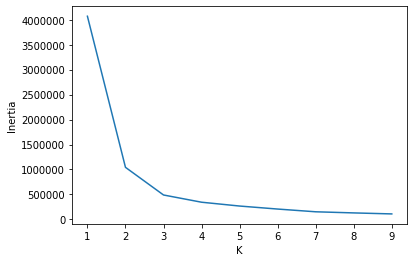

In [216]:
coordinates = df[['Latitude', 'Longitude']].values
k_values = range(1, 10)
inertia_values = []
for k in k_values:
    inertia_values.append(KMeans(k).fit(coordinates).inertia_)

plt.plot(range(1, 10), inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

The "elbow" within our Elbow plot points to a K of 3 That K-value is very low; limiting our scope to at-most 3 different geographic territories.

**Listing 12. 18. Using K-means to cluster cities into 3 groups**

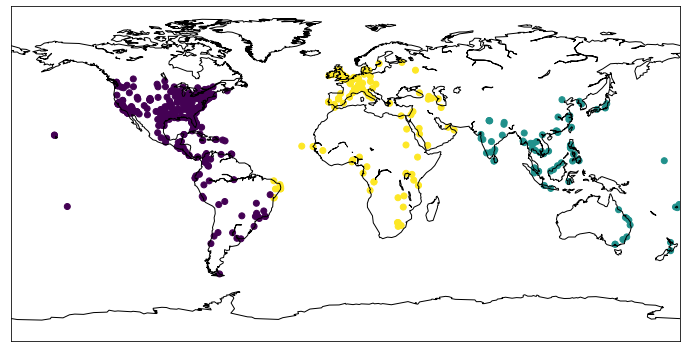

In [217]:
def plot_clusters(clusters, longitudes, latitudes):
    fig = plt.figure(figsize=(12, 10))

    map_plotter = Basemap()
    map_plotter.scatter(longitudes, latitudes, c=clusters, latlon=True,
                        marker='o', alpha=1.0)
    map_plotter.drawcoastlines()
    plt.show()
    
df['Cluster'] = KMeans(3).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

These continental categories are too broad to actually be useful. Perhaps our K was too low after all. We'll disregard the recommended K-value from the Elbow analysis, and double the size of K to 6.

**Using K-means to cluster cities into 6 groups**

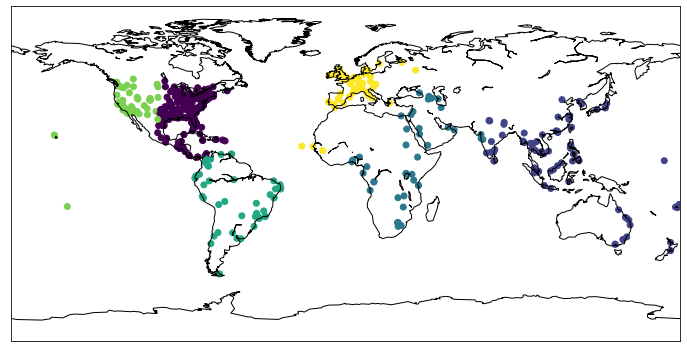

In [218]:
df['Cluster'] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

K-mean's sense of centrality is unable to properly distinguish between Africa, Europe and Asia. As an alternative approach, we can attempt to execute DBSCAN clustering. The DBSCAN algorithm takes as input any distance metric
of our choosing, allowing us to cluster on the great-circle distance between points.

**Listing 12. 20. Defining a NumPy-based great-circle metric**

In [219]:
def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0 

    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(coord1[0]),
                                                   cos(coord2[0]), 
                                                   sin(delta_y / 2) ** 2])
    return  2 * radius * asin(haversin ** 0.5)

With our distance metric in place, we are ready to run the DBSCAN algorithm. 

**Listing 12. 21. Using DBSCAN to cluster cities**

In [220]:
metric = great_circle_distance
dbscan = DBSCAN(eps=250, min_samples=3, metric=metric)
df['Cluster'] = dbscan.fit_predict(coordinates)

DBSCAN assigns -1 to outlier data-points that do not cluster. Lets remove these outliers from our table. Afterwards, we’ll plot the remaining results.

**Listing 12. 22. Plotting non-outlier DBSCAN clusters**

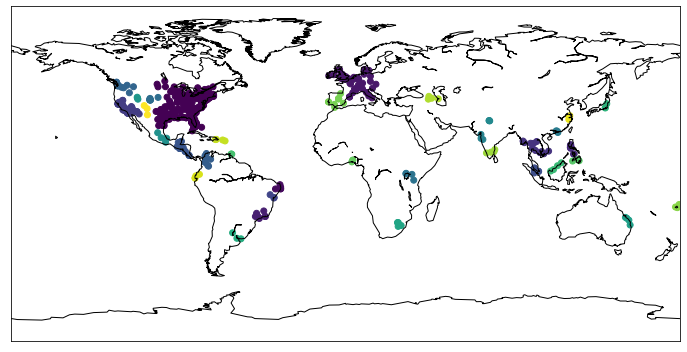

In [221]:
df_no_outliers = df[df.Cluster > -1]
plot_clusters(df_no_outliers.Cluster, df_no_outliers.Longitude,
              df_no_outliers.Latitude)

DBSCAN has does a decent job of generating discrete clusters within parts of South America, Asia, and Southern Africa. The Eastern United States however, falls into a single overly-dense cluster. Lets cluster US locations independently from the rest of the World. To do so, we will first assign country-codes across each of our cities.

**Listing 12. 23. Assigning country codes to cities**

In [222]:
def get_country_code(city_name):
    city = max(gc.get_cities_by_name(city_name), 
               key=lambda x: list(x.values())[0]['population'])
    return list(city.values())[0]['countrycode']

df['Country_code'] = df.City.apply(get_country_code)

The country-codes allow us to separate the data into 2 distinct `DataFrame` objects. The first object, `df_us`,  which hold all the United States locations. The second object, `df_not_us`, will hold all the remaining global cities.

**Listing 12. 24. Seperating US and global cities**

In [223]:
df_us = df[df.Country_code == 'US']
df_not_us = df[df.Country_code != 'US']

We've separated US and non-US cities. Now, we will need to re-cluster the coordinates within the 2 separated tables. 

**Listing 12. 25. Re-clustering extracted cities**

In [224]:
def re_cluster(input_df, eps):
    input_coord = input_df[['Latitude', 'Longitude']].values
    dbscan = DBSCAN(eps=eps, min_samples=3, 
                    metric=great_circle_distance)
    clusters = dbscan.fit_predict(input_coord)
    input_df = input_df.assign(Cluster=clusters)
    return input_df[input_df.Cluster > -1]

df_not_us = re_cluster(df_not_us, 250)
df_us = re_cluster(df_us, 125)

## 12.4. Extracting Insights from Location Clusters

Lets investigate the clustered data within the `df_not_us` table. We'll start by grouping the clustered results using the Pandas `groupby` method.

**Listing 12. 26. Grouping cities by cluster**

In [225]:
groups = df_not_us.groupby('Cluster')
num_groups = len(groups)
print(f"{num_groups} Non-US have been clusters detected")

31 Non-US have been clusters detected


31 global clusters have been detected. Lets sort these groups by size and count the headlines in the largest cluster.

**Listing 12. 27. Finding the largest cluster**

In [226]:
sorted_groups = sorted(groups, key=lambda x: len(x[1]), 
                       reverse=True)
group_id, largest_group = sorted_groups[0]
group_size = len(largest_group)
print(f"Largest cluster contains {group_size} headlines")

Largest cluster contains 51 headlines


The largest cluster contains 51 total headlines. Reading all these headlines individually will be a time-consuming process. We can save time by outputting just those headlines that represent the most central locations in the cluster.

**Listing 12. 28. Computing cluster centrality**

In [227]:
def compute_centrality(group):
    group_coords = group[['Latitude', 'Longitude']].values
    center = group_coords.mean(axis=0)
    distance_to_center = [great_circle_distance(center, coord)
                          for coord in group_coords]
    group['Distance_to_center'] = distance_to_center

Computing the centrality allows us to sort the grouped locations based on their distance to the centers, in order to output the most central headlines. Lets print the 5 most central headlines within our largest cluster.

**Listing 12. 29. Finding the central headlines in largest cluster**

In [228]:
def sort_by_centrality(group):
    compute_centrality(group)
    return group.sort_values('Distance_to_center', ascending=True)

largest_group = sort_by_centrality(largest_group)
for headline in largest_group.Headline.values[:5]:
    print(headline)

Mad Cow Disease Disastrous to Brussels
Scientists in Paris to look for answers
More Livestock in Fontainebleau are infected with Mad Cow Disease
Mad Cow Disease Hits Rotterdam
Contaminated Meat Brings Trouble for Bonn Farmers


The central headlines in largest_cluster focus on an outbreak of Mad Cow Disease within various European cities. We can confirm that the cluster’s locale is centered in Europe by outputting the top countries associated with cities in the cluster.

**Listing 12. 30. Finding the top 3 countries in largest cluster**

In [229]:
from collections import Counter
def top_countries(group):
    countries = [gc.get_countries()[country_code]['name']
                 for country_code in group.Country_code.values]
    return Counter(countries).most_common(3)


print(top_countries(largest_group))

[('United Kingdom', 19), ('France', 7), ('Germany', 6)]


Lets repeat this analysis across the next 4 largest global clusters.

**Listing 12. 31. Summarizing content within the largest clusters**

In [230]:
for _, group in sorted_groups[1:5]:
    sorted_group = sort_by_centrality(group)
    print(top_countries(sorted_group))
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

[('Philippines', 16)]
Zika afflicts patient in Calamba
Hepatitis E re-emerges in Santa Rosa
More Zika patients reported in Indang
Batangas Tourism Takes a Hit as Virus Spreads
Spreading Zika reaches Bacoor


[('Thailand', 5), ('Cambodia', 3), ('Vietnam', 2)]
More Zika patients reported in Chanthaburi
Thailand-Zika Virus in Bangkok
Zika case reported in Phetchabun
Zika arrives in Udon Thani
More Zika patients reported in Kampong Speu


[('El Salvador', 3), ('Nicaragua', 2), ('Guatemala', 2)]
Zika arrives in Tegucigalpa
Zika Reported in Ilopango
More Zika cases in Soyapango
Zika worries in San Salvador
Spike of Rabies Cases in Managua


[('Canada', 10)]
Rumors about Pneumonia spreading in Ottawa have been refuted
More people in Toronto are infected with Hepatitis E every year
St. Catharines Patient in Critical Condition after Contracting Dengue
Varicella has Arrived in Milton
Rabies Exposure in Hamilton




Lets turn our attention to the US clusters. We'll start by visualizing the clusters on a map of the United States.

**Listing 12. 32. Plotting United States DBSCAN clusters**

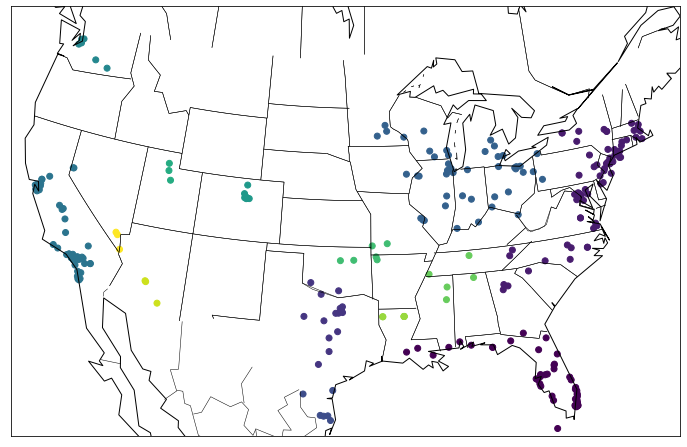

In [231]:
fig = plt.figure(figsize=(12, 10))
map_lcc = Basemap(projection='lcc', llcrnrlon=-119,
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                   lat_1=33, lat_2=45, lon_0=-95)

map_lcc.scatter(df_us.Longitude.values, df_us.Latitude.values,
                c=df_us.Cluster, latlon=True)
map_lcc.drawcoastlines()
map_lcc.drawstates()
plt.show()

The visualized map yields reasonable outputs. We'll proceed to analyze the top 5 US clusters by printing their centrality-sorted headlines.

**Listing 12. 33. Summarizing content within the largest US clusters**

In [232]:
us_groups = df_us.groupby('Cluster')
us_sorted_groups = sorted(us_groups, key=lambda x: len(x[1]),
                         reverse=True)
for _, group in us_sorted_groups[:5]:
    sorted_group = sort_by_centrality(group)
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

Schools in Bridgeton Closed Due to Mumps Outbreak
Philadelphia experts track pandemic
Vineland authorities confirmed the spread of Chlamydia
Baltimore plans for Zika virus
Will Swine Flu vaccine help Annapolis?


Bradenton Experiences Zika Troubles
Tampa Bay Area Zika Case Count Climbs
Zika Strikes St. Petersburg
New Zika Case Confirmed in Sarasota County
Zika spreads to Plant City


Rhinovirus Hits Bakersfield
Schools in Tulare Closed Due to Mumps Outbreak
Santa Barbara tests new cure for Hepatitis C
New medicine wipes out West Nile Virus in Ventura
Zika symptoms spotted in Hollywood


How to Avoid Hepatitis E in South Bend
Hepatitis E Hits Hammond
Chicago's First Zika Case Confirmed
Rumors about Hepatitis C spreading in Darien have been refuted
Rumors about Rotavirus Spreading in Joliet have been Refuted


More Zika patients reported in Fort Worth
Outbreak of Zika in Stephenville
Zika symptoms spotted in Arlington
Dallas man comes down with case of Zika
Zika spreads to Lewisville




Lets plot one additional image. It will summarize the menacing scope of the spreading Zika epidemic. The image will display all US and global clusters where Zika is mentioned in more than 50% of article headlines.

**Listing 12. 34. Plotting Zika clusters**

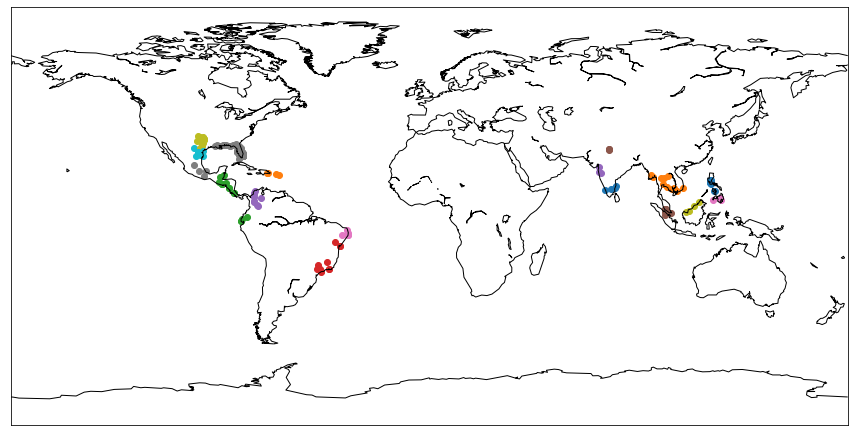

In [233]:
def count_zika_mentions(headlines):
    zika_regex = re.compile(r'\bzika\b', 
                            flags=re.IGNORECASE)
    zika_count = 0
    for headline in headlines:
        if zika_regex.search(headline): 
            zika_count += 1
    
    return zika_count

fig = plt.figure(figsize=(15, 15))
map_plotter = Basemap()

for _, group in sorted_groups + us_sorted_groups:
    headlines = group.Headline.values
    zika_count = count_zika_mentions(headlines)
    if float(zika_count) / len(headlines) > 0.5:
        map_plotter.scatter(group.Longitude.values, 
                            group.Latitude.values,
                            latlon=True)
map_plotter.drawcoastlines()
plt.show()